In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import unidecode

import warnings
warnings.simplefilter('ignore')

from wordcloud import WordCloud

pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [44]:
all_cards = pd.read_json('Data/commander_legal.json')

In [45]:
all_cards.drop(columns=['all_parts','artist','color_indicator','games','highres_image','lang','layout',
                        'oversized','preview','printed_text','printed_type_line','promo','released_at','reprint',
                        'reserved','set','set_name','set_search_uri','textless'],inplace=True)

In [46]:
all_cards.head()

,cmc,color_identity,colors,edhrec_rank,image_uris,legalities,loyalty,mana_cost,name,oracle_text,power,scryfall_uri,tcgplayer_id,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
10000,2,[R],[R],12078.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{1}{R},Fiery Conclusion,"As an additional cost to cast this spell, sacr...",None,https://scryfall.com/card/pca/42/fiery-conclus...,125418.0,None,Instant,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10001,3,[R],[R],13953.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{2}{R},Erratic Explosion,Choose any target. Reveal cards from the top o...,None,https://scryfall.com/card/pca/41/erratic-explo...,125413.0,None,Sorcery,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10003,2,[R],[R],8707.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{1}{R},Arc Trail,Arc Trail deals 2 damage to any target and 1 d...,None,https://scryfall.com/card/pca/39/arc-trail?utm...,125380.0,None,Sorcery,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10004,1,[B],[B],3614.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{B},Tormented Soul,Tormented Soul can't block and can't be blocked.,1,https://scryfall.com/card/pca/38/tormented-sou...,125522.0,1,Creature — Spirit,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10005,5,[B],[B],2455.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{4}{B},Throat Slitter,"Ninjutsu {2}{B} ({2}{B}, Return an unblocked a...",2,https://scryfall.com/card/pca/37/throat-slitte...,125519.0,2,Creature — Rat Ninja,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


1. Choose Commander
2. Filter cards to match commander color identity

**REMOVE CARDS FROM DF THAT ARE ALREADY IN THE DECK**
3. Include cards that are considered staples
4. LDA topic modeling on remaining cards
5. Include cards that are with the most similar topic scores to chosen card
    
    5a. More topics for better fit?

In [222]:
def plot_wcs(topic_words):
    c=0
    for topic in topic_words:
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        merged = {}
        for d in list(topic.values())[0]:
            merged.update(d)
        wc = WordCloud(background_color='white').generate_from_frequencies(merged)
        ax[0].set_title(f'Word Cloud',size=25,y=1.1)
        ax[0].imshow(wc,interpolation='bilinear')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].axis('off')
        
        ax[1].set_title('Top 10 TF-IDF Vectorizer',size=25)
        ax[1].bar(merged.keys(),merged.values(),edgecolor='black',linewidth=[1])
        ax[1].set_xticklabels(merged.keys(), rotation=45)
        ax[1].set_ylabel('TF-IDF Score',size=15)
        ax[1].set_xlabel('Tokens',size=15)
        fig.suptitle(f'Topic {c}',size=30,y=1.03)
        c += 1

In [226]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append({topic_idx:[{feature_names[i]:topic[i]} for i in topic.argsort()[:-no_top_words-1:-1]]})
#         print ("Topic %d:" % (topic_idx),end='\t')
#         print ("\n\t\t".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]),end='\n\n')
    return topics

In [357]:
def get_topics(corpa,n_topics=10):
    stop = list(set(stopwords.words('english')))
    names = [unidecode.unidecode(card_name.lower().replace(',','  ').replace('-',' ')).split() for card_name in corpa['name']]
    for name in names:
        stop.extend(name)
    stop.extend(['adiyah', 'adventurers', 'aliban', 'aquitect', 'arenson', 'arguel', 'arnjlot',
                 'ashnod', 'ata', 'avenant', 'barl', 'barrin', 'belbe', 'briber', 'cathars', 
                 'cogworker', 'conqueror', 'cosi', 'coursers', 'curtains', 'debtor', 'debtors', 
                 'delif', 'descendants', 'dispeller', 'drafna', 'eladamri', 'embalmer', 'fa', 
                 'farrel', 'feroz', 'feudkiller', 'fireforger', 'fool', 'forebear', 'geistcatcher',
                 'geomancer', 'ghalma', 'glassblower', 'grafdigger', 'guildmages', 'hadana',
                 'horncaller', 'hurkyl', 'ihsan', 'inventors', 'iona', 'ixalan', 'ixalli', 'ja', 
                 'jabari', 'jandor', 'journeyer', 'kaboom', 'kanar', 'kinjalli', 'kuar', 'leovold',
                 'liar', 'loreseeker', 'love', 'magewright', 'martyrs', 'mercadia', 'metalspinner', 
                 'minions', 'misfortune', 'mourner', 'murderer', 'nevinyrral', 'nightbird', 'orim', 
                 'outlaws', 'pemmin', 'primevals', 'rivals', 'rofellos', 'roilmage', 'rrik', 
                 'runechanter', 'scalebane', 'seafarer', 'seht', 'sek', 'shaila', 'shiv', 'sinstriker',
                 'skywhaler', 'slayers', 'soulcatchers', 'sunbird', 'sunbringer', 'suq', 'talara',
                 'telim', 'terashi', 'thespian', 'thieves', 'tilonalli', 'tormod', 'tovolar', 'trapfinder',
                 'trapmaker', 'ula', 'vance', 'whitesun', 'wit', 'wizards', 'wolfcaller', 'wolfhunter', 
                 'wolfrider', 'woodcutter', 'woodweaver', 'wren', 'zephid','target'])
    stop = list(set(stop))
    sents = [text.strip().lower().split('\n') for text in corpa['oracle_text'].fillna('').tolist()]
    temp = []
    for sent in sents:
        temp.extend(sent)
    sents = temp
    vec = TfidfVectorizer(max_df=0.9, min_df=10, stop_words=stop,ngram_range=(1,2))
    sent_vec_ft = vec.fit_transform(sents)
    sent_vec_ft_words = vec.get_feature_names()
    lda=LatentDirichletAllocation(n_components=10,random_state=30,verbose=0,n_jobs=-1,max_iter=50)
    lda.fit(sent_vec_ft)
    
    cards = [text.strip().lower().replace('\n',' ') for text in corpa['oracle_text'].fillna('').tolist()]
    card_vec_ft = vec.transform(cards)
    
    topic_df = lda.transform(card_vec_ft)
    
    topic_words = display_topics(lda, sent_vec_ft_words, 10)
    plot_wcs(topic_words)
    
    return pd.DataFrame(topic_df,index=corpa.index)

In [358]:
def deck_builder(commander):
    legal_cards = pd.read_json('Data/commander_legal.json')
    legal_cards.drop(columns=['all_parts','artist','color_indicator','games','highres_image','lang','layout',
                            'oversized','preview','printed_text','printed_type_line','promo','released_at','reprint',
                            'reserved','set','set_name','set_search_uri','textless'],inplace=True)
    cmdr = legal_cards[legal_cards['name']==commander]
    # For every card `c`, check that every color `a` in its color identity 
    # is also in the color identity of the commander.
    legal_cards = legal_cards[[all([a in cmdr['color_identity'].tolist()[0] for a in c])
                               for c in legal_cards['color_identity']]]
    # Get the topic scores for the legal cards
    topics_df = get_topics(legal_cards,n_topics=10)
    return topics_df
    deck = pd.DataFrame(columns=all_cards.columns)
    deck = deck.append(cmdr)
    legal_cards.drop(cmdr.index,inplace=True)
    colors = set(map(lambda x: x.lower(),set(cmdr['color_identity'].tolist()[0])))
    if len(colors)==0:
        colors = 'colorless'
    else:
        colors = [c for c in legal_cards.columns if set(c)==colors][0]
    staples = legal_cards[legal_cards[colors]]
    deck = deck.append(staples)
    legal_cards.drop(staples.index.tolist(),inplace=True)
    manacount = 0
    manacount += len(deck[deck['type_line'].str.contains('Land')])
    manacount += len(deck[(deck['type_line'].str.contains('Artifact'))&(deck['oracle_text'].str.lower().str.contains('add'))])//3
    print(manacount)
    return deck 

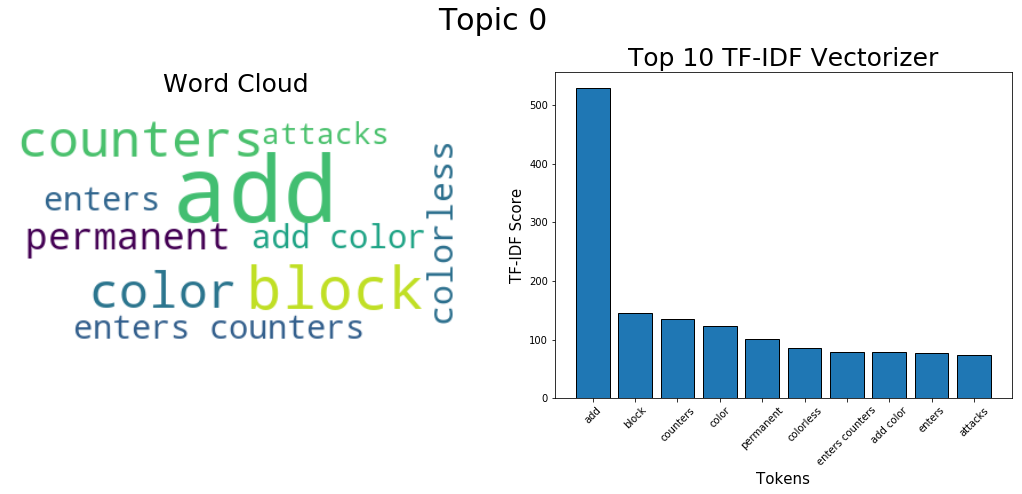

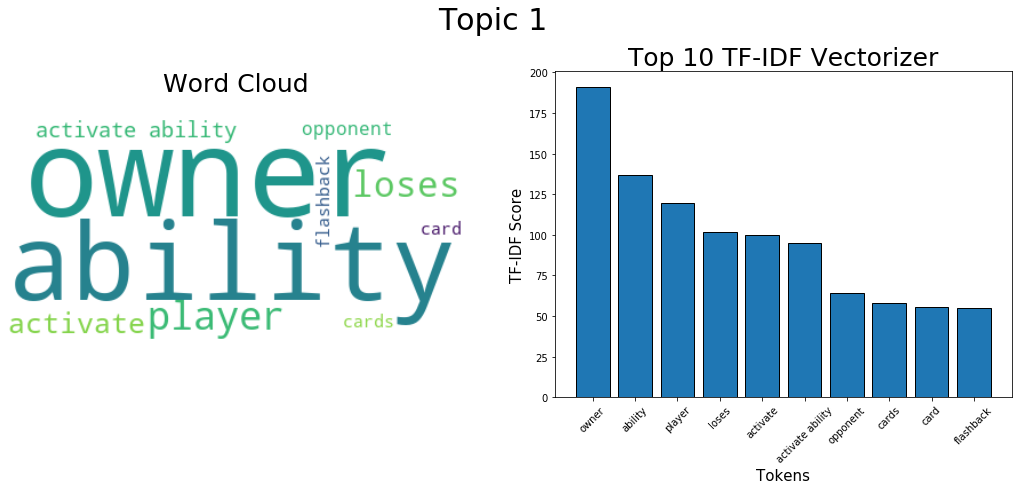

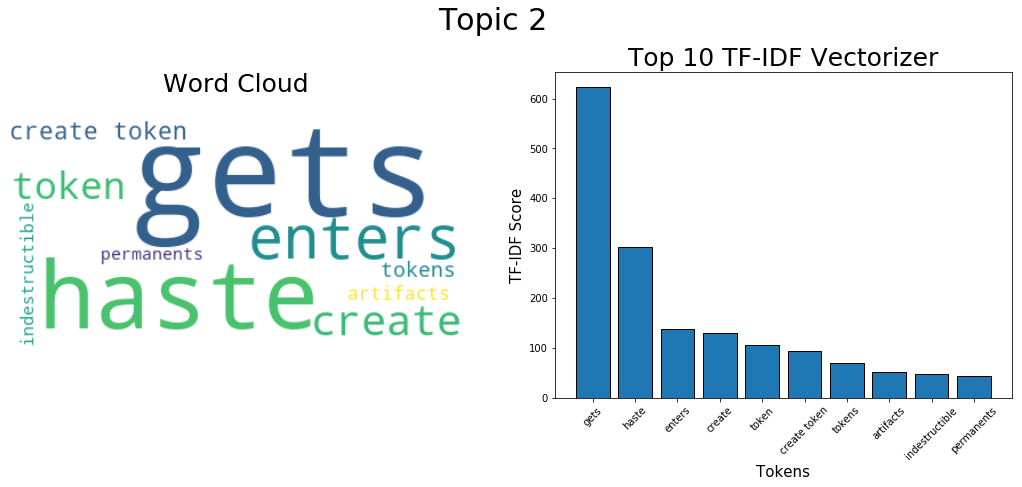

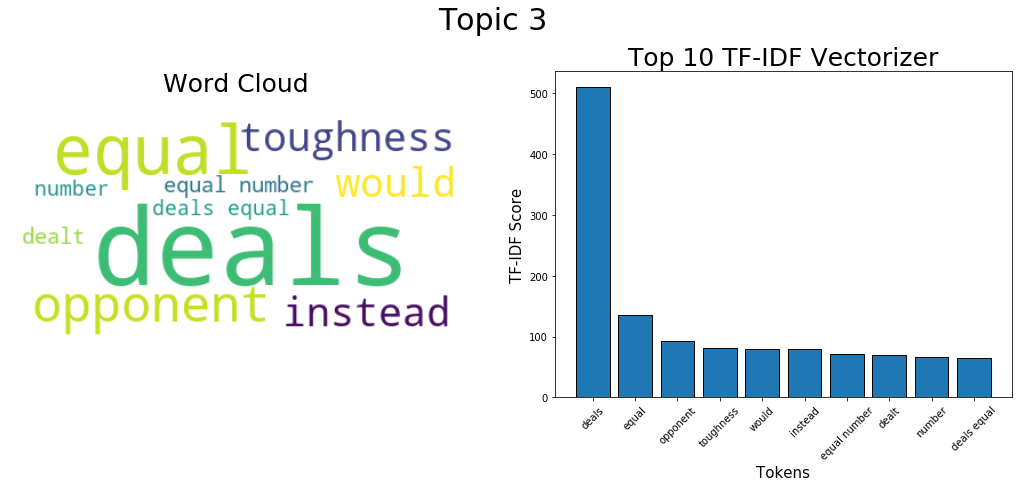

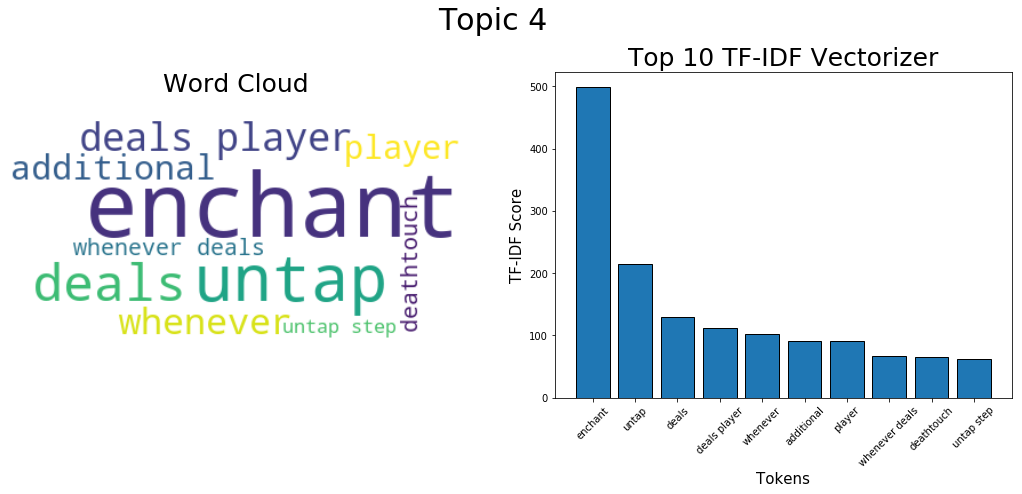

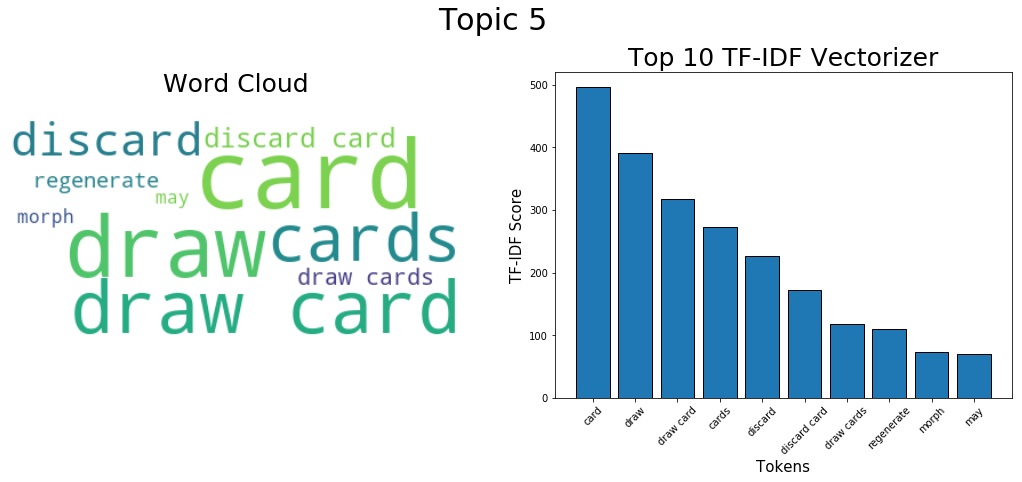

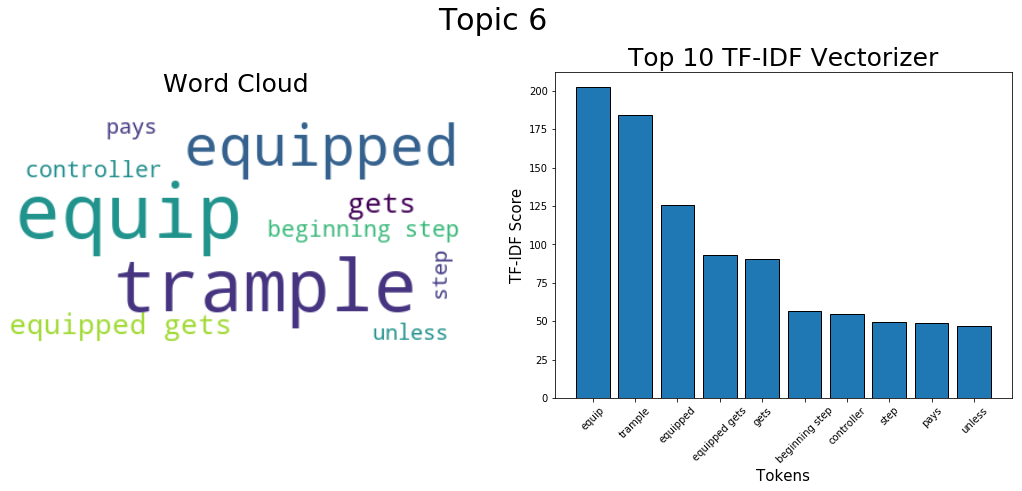

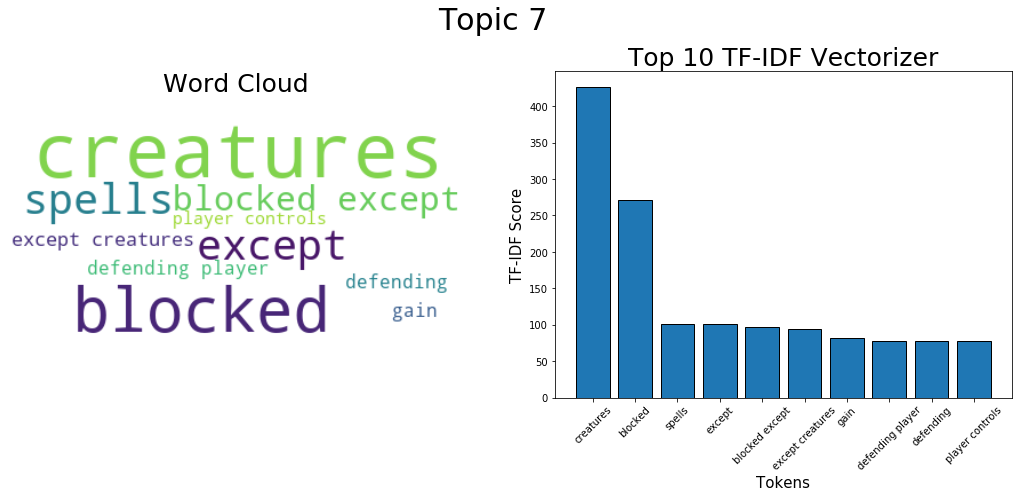

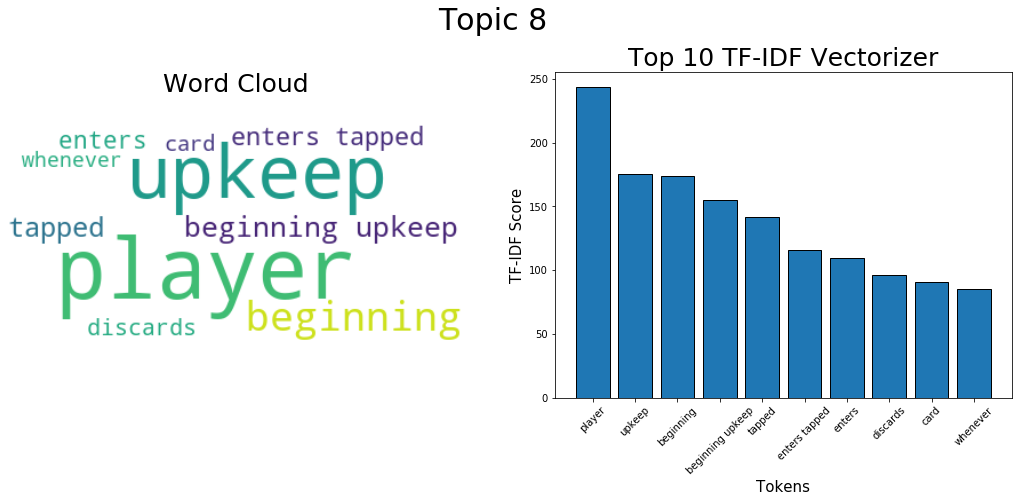

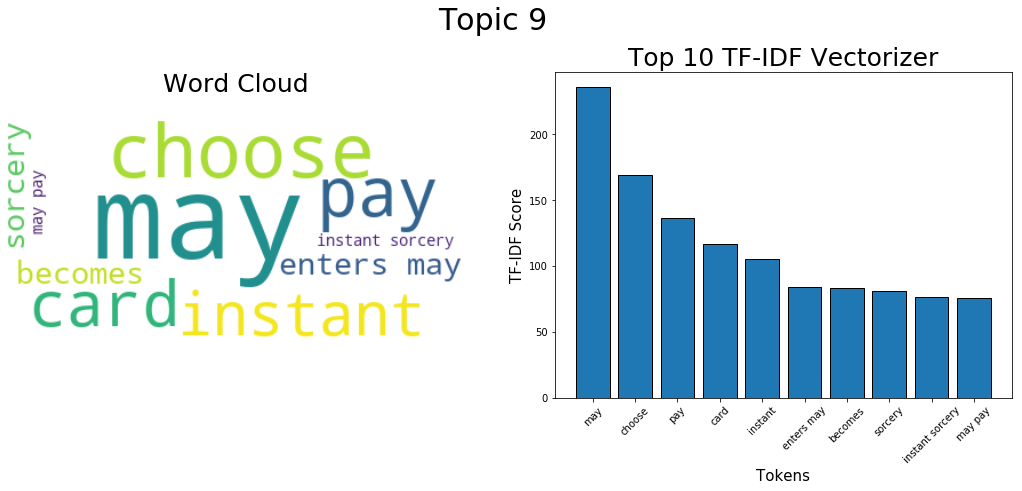

In [370]:
deck = deck_builder('Nicol Bolas')

In [369]:
all_cards.loc[[41925]]

,cmc,color_identity,colors,edhrec_rank,image_uris,legalities,loyalty,mana_cost,name,oracle_text,power,scryfall_uri,tcgplayer_id,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
41925,1,[],[],11746.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,0,{1},Helm of Chatzuk,"{1}, {T}: Target creature gains banding until ...",None,https://scryfall.com/card/5ed/376/helm-of-chat...,2192.0,None,Artifact,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [371]:
deck.sort_values(0,ascending=False).head()

,0,1,2,3,4,5,6,7,8,9
12655,0.839298,0.017855,0.017857,0.017856,0.017855,0.017856,0.017855,0.017855,0.017858,0.017855
17872,0.823545,0.019604,0.019608,0.019602,0.019604,0.019604,0.019610,0.019603,0.019603,0.019616
7688,0.819020,0.020107,0.020108,0.020107,0.020106,0.020107,0.020105,0.020105,0.020112,0.020123
13662,0.805690,0.021589,0.021593,0.021589,0.021589,0.021592,0.021589,0.021589,0.021590,0.021590
13660,0.805690,0.021589,0.021593,0.021589,0.021589,0.021592,0.021589,0.021589,0.021590,0.021590


In [351]:
deck[(deck['type_line'].str.lower().str.contains('artifact'))&(deck['oracle_text'].str.lower().str.contains('add'))]

,cmc,color_identity,colors,edhrec_rank,image_uris,legalities,loyalty,mana_cost,name,oracle_text,power,scryfall_uri,tcgplayer_id,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
15883,2,[U],[],705.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{2},Sky Diamond,Sky Diamond enters the battlefield tapped.\n{T...,None,https://scryfall.com/card/c14/269/sky-diamond?...,94205.0,None,Artifact,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3857,2,[],[],24.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{2},Mind Stone,"{T}: Add {C}.\n{1}, {T}, Sacrifice Mind Stone:...",None,https://scryfall.com/card/c18/210/mind-stone?u...,171133.0,None,Artifact,False,True,True,True,True,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4771,2,[],[],39.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{2},Thought Vessel,You have no maximum hand size.\n{T}: Add {C}.,None,https://scryfall.com/card/cm2/224/thought-vess...,166917.0,None,Artifact,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4817,6,[],[],116.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{6},Caged Sun,"As Caged Sun enters the battlefield, choose a ...",None,https://scryfall.com/card/cm2/178/caged-sun?ut...,166754.0,None,Artifact,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
501,4,[],[],54.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{4},Thran Dynamo,{T}: Add {C}{C}{C}.,None,https://scryfall.com/card/c19/225/thran-dynamo...,196462.0,None,Artifact,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
505,1,[],[],1.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{1},Sol Ring,{T}: Add {C}{C}.,None,https://scryfall.com/card/c19/221/sol-ring?utm...,196523.0,None,Artifact,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5453,5,[],[],33.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,{5},Gilded Lotus,{T}: Add three mana of any one color.,None,https://scryfall.com/card/dom/215/gilded-lotus...,164292.0,None,Artifact,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [352]:
deck[deck['type_line'].str.lower().str.contains('land')]

,cmc,color_identity,colors,edhrec_rank,image_uris,legalities,loyalty,mana_cost,name,oracle_text,power,scryfall_uri,tcgplayer_id,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
1292,0,[U],[],311.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Lonely Sandbar,Lonely Sandbar enters the battlefield tapped.\...,None,https://scryfall.com/card/mh1/242/lonely-sandb...,191287.0,None,Land,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
153,0,[U],[],9629.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Mystic Sanctuary,({T}: Add {U}.)\nMystic Sanctuary enters the b...,None,https://scryfall.com/card/eld/247/mystic-sanct...,199417.0,None,Land — Island,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3814,0,[U],[],223.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Halimar Depths,Halimar Depths enters the battlefield tapped.\...,None,https://scryfall.com/card/c18/253/halimar-dept...,171215.0,None,Land,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
446,0,[],[],13.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Temple of the False God,{T}: Add {C}{C}. Activate this ability only if...,None,https://scryfall.com/card/c19/280/temple-of-th...,196528.0,None,Land,False,True,True,False,True,False,True,True,True,True,True,False,True,False,True,True,False,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True
458,0,[],[],9.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Reliquary Tower,You have no maximum hand size.\n{T}: Add {C}.,None,https://scryfall.com/card/c19/268/reliquary-to...,196505.0,None,Land,False,False,True,True,False,True,True,True,False,False,True,True,True,False,True,True,True,True,False,False,True,False,True,True,False,True,False,True,False,True,False,False,True
465,0,[],[],34.0,{'small': 'https://img.scryfall.com/cards/smal...,legal,None,,Myriad Landscape,Myriad Landscape enters the battlefield tapped...,None,https://scryfall.com/card/c19/261/myriad-lands...,196489.0,None,Land,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
